[0.0, 14.0, 2.0, 7.0, 12.0, 4.5, 9.5, 2.0, 12.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.5, -6.0]
[0.0, 14.0, 2.0, 7.0, 12.0, 4.5, 9.5, 2.0, 12.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.5, -6.0]
[2.0, 7.0, 12.0, 4.5, 9.5, 2.0, 12.0, 7.0, 4.0, 4.5, -6.0]
[2, 3, 4, 5, 6, 7, 8, 9, 17, 18, 19] [10, 12, 15, 13, 16, 14, 11, 0, 1]
[0.0, 14.0, 2.0, 7.0, 12.0, 4.5, 9.5, 2.0, 12.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.5, -6.0]


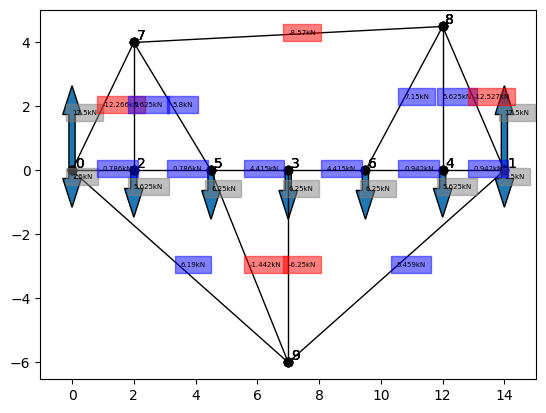

Initial Cost: 1812.78
0 0 2
1 4 1
2 2 5
3 3 5
4 3 6
5 6 4
6 7 0
7 7 2
8 7 5
9 7 8
10 8 6
11 8 4
12 8 1
13 9 3
14 9 5
15 9 0
16 9 1
[0, 1, 2, 3, 4, 5]
[nan nan nan nan nan nan nan nan nan nan nan]
[[nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]]


In [20]:
from truss_casadi import *
import numpy as np
import scipy as sp
from scipy.optimize import NonlinearConstraint, minimize, Bounds, shgo

truss, bridge_joints, xs = open_file("designs/test17.json", y_shift=0, flip=False)

unknown_indices = list(np.arange(len(truss.joints)*2))
known_indices = []

for j in bridge_joints:
    # unknown_indices = np.delete(unknown_indices, j+len(truss.joints))
    unknown_indices.remove(j+len(truss.joints))
    known_indices.append(j+len(truss.joints))

# unknown_indices = np.delete(unknown_indices, bridge_joints[0])
unknown_indices.remove(bridge_joints[0])
unknown_indices.remove(bridge_joints[-1])
# unknown_indices = np.delete(unknown_indices, bridge_joints[-1])
known_indices.append(bridge_joints[0])
known_indices.append(bridge_joints[-1])

print(xs)
def correct(X):
    xs_ = xs.copy()
    for i in range(len(unknown_indices)):
        xs_[unknown_indices[i]] = X[i] 
    return xs_

unknowns = []
for i in unknown_indices:
    unknowns.append(xs[i])
print(unknowns)
print(unknown_indices, known_indices)
print(correct(unknowns))

cost = Function('cost', [truss.xs], [truss.cost])
real_cost = Function('real_cost', [truss.xs], [truss.real_cost])
cost_jac_ = Function('cost_jac', [truss.xs], [jacobian(truss.cost, truss.xs)])
[H, g] = hessian(truss.cost, truss.xs)
cost_hess_ = Function('cost_hess', [truss.xs], [H])
def j(x):
    j_ = np.array(cost_jac_(correct(x)))[...,unknown_indices].flatten()
    print(j)
    return j
cost_jac = lambda x: j(x)
cost_hess = lambda x: np.array(cost_hess_(correct(x)))[unknown_indices, :][:, unknown_indices]




truss.plot(xs, plot_member=True, plot_external=True)

print("Initial Cost:",real_cost(xs))

bridge_links = []
for i, link in enumerate(truss.links):
    print(i, link.i0, link.i1)
    if (link.i0 in bridge_joints and link.i1 in bridge_joints) and i not in bridge_links:
        bridge_links.append(i)

print(bridge_links)

print(cost_jac(xs))
print(cost_hess(xs))

In [21]:
# def correct(X):   
#     X[bridge_joints[0]] = 0
#     X[bridge_joints[-1]] = 14
#     for j in bridge_joints:
#         X[j+len(truss.joints)] = 0
#         X[j+len(truss.joints)] = 0

#     return X





In [22]:
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

nonlinear_constraints = []
for i, link in enumerate(truss.links):
    print(i, link.length)

print(len(truss.links))

for i in range(len(truss.links)):
    upper = np.inf
    if(i in bridge_links):
        upper = 3.5
    nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(Function('length{0}'.format(i),[truss.xs],[truss.links[i].length])(correct(x))), 1, upper))
    nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(Function('length{0}'.format(i),[truss.xs],[truss.links[i].force])(correct(x))), -6*3, 9*3))
for i in range(len(truss.joints)):
    if(truss.joints[i].type == JointType.PIN):
            nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(correct(x)[i]), 0, 0))
    if(truss.joints[i].type == JointType.ROLLER):
            nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(correct(x)[i]), 14, 14))
    # if(i in bridge_joints):
    #     nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(x[i+len(truss.joints)]), 0, 0))

lower = [-14] * len(unknowns)
upper = [14] * len(unknowns)

# for i in bridge_joints:
#     lower[i+len(truss.joints)] = 0
#     upper[i+len(truss.joints)] = 0
# lower[bridge_joints[0]] = 0
# upper[bridge_joints[0]] = 0
# lower[bridge_joints[-1]] = 14
# upper[bridge_joints[-1]] = 14

bounds = tuple(zip(lower, upper))
print(xs)
print(bounds)

print(nonlinear_constraints)

res = minimize(lambda x: real_cost(correct(x)), unknowns, jac=cost_jac, hess=cost_hess, bounds=bounds, method='trust-constr',options={'initial_constr_penalty':1, 'maxiter':1000}, constraints=[*nonlinear_constraints])

0 sqrt((sq((xs_0-xs_2))+sq((xs_10-xs_12))))
1 sqrt((sq((xs_4-xs_1))+sq((xs_14-xs_11))))
2 sqrt((sq((xs_2-xs_5))+sq((xs_12-xs_15))))
3 sqrt((sq((xs_3-xs_5))+sq((xs_13-xs_15))))
4 sqrt((sq((xs_3-xs_6))+sq((xs_13-xs_16))))
5 sqrt((sq((xs_6-xs_4))+sq((xs_16-xs_14))))
6 sqrt((sq((xs_7-xs_0))+sq((xs_17-xs_10))))
7 sqrt((sq((xs_7-xs_2))+sq((xs_17-xs_12))))
8 sqrt((sq((xs_7-xs_5))+sq((xs_17-xs_15))))
9 sqrt((sq((xs_7-xs_8))+sq((xs_17-xs_18))))
10 sqrt((sq((xs_8-xs_6))+sq((xs_18-xs_16))))
11 sqrt((sq((xs_8-xs_4))+sq((xs_18-xs_14))))
12 sqrt((sq((xs_8-xs_1))+sq((xs_18-xs_11))))
13 sqrt((sq((xs_9-xs_3))+sq((xs_19-xs_13))))
14 sqrt((sq((xs_9-xs_5))+sq((xs_19-xs_15))))
15 sqrt((sq((xs_9-xs_0))+sq((xs_19-xs_10))))
16 sqrt((sq((xs_9-xs_1))+sq((xs_19-xs_11))))
17
[0.0, 14.0, 2.0, 7.0, 12.0, 4.5, 9.5, 2.0, 12.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.5, -6.0]
((-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14))
[<scipy.optimiz

           message: The maximum number of function evaluations is exceeded.
           success: False
            status: 0
               fun: 2350.6973703193057
                 x: [ 3.060e+00  8.041e+00  1.165e+01  5.646e+00  9.582e+00
                      2.713e+00  1.281e+01  7.376e+00  4.952e+00  2.245e+00
                     -9.244e-01]
               nit: 1000
              nfev: 1001
              njev: 551
              nhev: 551
          cg_niter: 1685
      cg_stop_cond: 2
              grad: [ 1.049e+00  1.845e+02  8.103e+00 -8.993e+01  6.645e+01
                     -3.819e+01  4.159e+01 -1.133e+02  9.189e+01  4.999e+01
                      7.788e+01]
   lagrangian_grad: [ 9.062e-01  1.518e+01  9.829e+00  1.834e+00  2.313e+01
                      9.020e+00  9.474e+00 -8.808e+00  1.722e+01 -1.632e+01
                     -2.871e+00]
            constr: [array([ 3.060e+00]), array([ 2.594e+01]), array([ 2.353e+00]), array([ 8.123e+00]), array([ 2.586e+00]), array([ 2.6

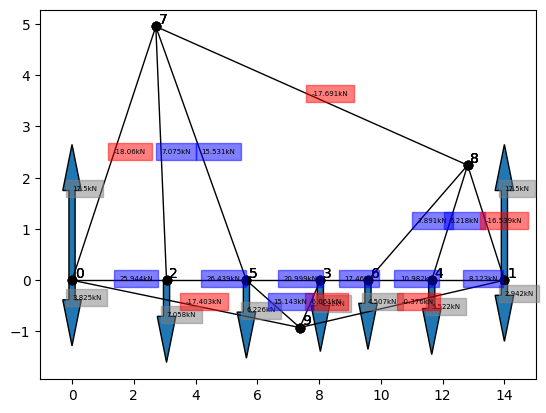

2350.7


In [23]:
x = correct(res.x)
print(res)
for link in truss.links:
    print(float(Function('length',[truss.xs],[link.length])(x)))

print(x)
truss.plot(x, plot_member=True, plot_external=True)

print(real_cost(x))

In [24]:
x_test = [0.0, 14.0, 3.5, 7, 10.5, 4.42996656570212, 9.655462206325538, 1.7870875610913732, 12.166366150478423, 0.0, 0.0, 0.0, 0.0, 0.0, -3.447233938992347, -3.3830525725910925, -1.981717653459234, -2.013753460497979]
print(real_cost(x_test))

RuntimeError: Error in Function::call for 'real_cost' [SXFunction] at .../casadi/core/function.cpp:330:
.../casadi/core/function_internal.hpp:1644: Input 0 (i0) has mismatching shape. Got 18-by-1. Allowed dimensions, in general, are:
 - The input dimension N-by-M (here 20-by-1)
 - A scalar, i.e. 1-by-1
 - M-by-N if N=1 or M=1 (i.e. a transposed vector)
 - N-by-M1 if K*M1=M for some K (argument repeated horizontally)
 - N-by-P*M, indicating evaluation with multiple arguments (P must be a multiple of 1 for consistency with previous inputs)

In [ ]:
# opti = casadi.Opti()

# shape = len(xs)

# x = opti.variable(shape)

# def constraints():
#     for link in truss.links:
#         leng_fun = Function('leng_fun', [truss.xs], [link.length])
#         force_fun = Function('force_fun', [truss.xs], [link.force])   

#         # Constraint: length of each link cannot be less than 1
#         opti.subject_to(leng_fun(x) > 1)
#         # Constraint: force of each link must be within -27 and 18
#         opti.subject_to(opti.bounded(-9*3, force_fun(x), 6*3))

#     half_length = shape/2

#     # Constraint: First bridge joint must be at x=0
#     opti.subject_to(x[bridge_joints[0]] == 0)
#     # Constraint: Last bridge joint must be at x=14
#     opti.subject_to(x[bridge_joints[-1]] == 14)

#     for i in range(len(bridge_joints)-1):
#         i0 = bridge_joints[i]
#         i1 = bridge_joints[i+1]
#         print(i0, i1)
#         # Constraint: Each bridge joint must not be more than 3.5m apart
#         opti.subject_to(x[i1] - x[i0] < 3.5)
#         # Constraint: Bridge joints must be in order of ascending X value
#         opti.subject_to(x[i0] < x[i1])
#         # Constraint: Bridge joint y values = 0
#         opti.subject_to(x[i1+half_length] == 0)
#         if(i == 0):
#             opti.subject_to(x[i0+half_length] == 0)
    
#     # for i, joint in enumerate(truss.joints):
#     #     if(joint.type == JointType.PIN):
#     #         opti.subject_to(x[i] == 0)
#     #     if(joint.type == JointType.ROLLER):
#     #         opti.subject_to(x[i] == 14)

# constraints()

# cost = Function('cost', [truss.xs], [truss.cost])
# grad = Function('grad', [truss.xs], [casadi.gradient(truss.cost, truss.xs)])
# print(cost(xs), grad(xs))
# opti.minimize(cost(x))

# solver_options = {"ipopt.tol": 1e-8}

# opti.solver('ipopt', solver_options)


In [ ]:
# original_cost = cost(xs)
# opti.set_initial(x, xs)
# sol = opti.solve()
# sol_mat = np.asarray(sol.value(x))

In [ ]:
# truss.plot(sol_mat, plot_external=True, plot_member=True)
# truss.plot(sol_mat)
# print("Optimization Complete. Original Cost = {0}, Final Cost = {1}".format(truss.real_cost(xs), truss.real_cost(sol_mat)))
# print("Solution:",sol_mat)